In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import platform
#import SIRD_Model_Experimental
import SIRD_Model
from sklearn import linear_model

def loadData(filename):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    for lv in rd: #generating the data matrix
        data.append(lv)
    header = data[0] #get the labels
    infectionData=(data[1:]) #data without the labels
    infectionData = np.array(infectionData)
    dates = infectionData[:,header.index("Dates")]
    infected = infectionData[:,header.index("Infected")]
    recovered = infectionData[:,header.index("Recovered")]
    deaths = infectionData[:,header.index("Deaths")]
    vacc = infectionData[:,header.index("Vaccinated")]
    vacc = vacc.astype(float)
    deaths = deaths.astype(float)
    recovered = recovered.astype(float)
    infected = infected.astype(float)
    return dates, infected, recovered, deaths, vacc



def getPop(state):
    path="../Data/"
    csvfile=open(path+"2020 Population Data.csv", newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[3:])
    for i in range(len(aData)):
        if state in aData[i][0]:
            pop = float(aData[i][1]) * 1000000
    return pop

def approxRecovered(infect,dead):
    recovG = np.zeros(len(infect))
    for i in range(len(infect) - 14):
        recovG[i + 14] = infect[i] - dead[i + 14]
    return recovG



def getBeta(pop, q, infect, dead,winSize):
    

    sigma = regressionSlopeSeries(infect, winSize )
    recov = approxRecovered(infect,dead)
    infectN = infect - recov - dead
    Z = infect 
    Zt = Z 
    It = infectN 
    halfwin = winSize // 2

    Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
    for i in range(len(Beta)):
        if np.isnan(Beta[i]):
            Beta[i] = 0
        if np.isinf(Beta[i]):
            Beta[i] = 0
    return Beta
    
    
def getRegressionSlope(points):
    """
    Takes a given number of points and outputs slope determined by linear regression
    Times can be included, if they are not, the indexes are assumed to be the times, starting from 0
    """
    timeArray = np.ones((len(points), 2))
    timeArray[:,1]  = np.arange(len(points))
    pointArray = np.array(points)
    point_slope, res, _, _ = np.linalg.lstsq(timeArray, (pointArray), rcond=None)
    slope = point_slope[1]
    return res, slope

def regressionSlopeSeries(points, window):
    """
    Given a series of points and a window size, estimates the slope at each point
    Outputs both the estimated slopes and regression errors for all applicable points
    If times list is provided, each of the included times should match up respectively with the points
    Window should be odd, if it isn't it will automatically be interpreted as one larger than the argument passed
    """
    # cut the window in half so we know how long it extends on both sides
    half_window = window//2
    num_points = len(points)
    slopes = []

    for i in range(num_points):
        # if there are not enough previous values to satisfy window size, continue
        if i < half_window:
            continue
        # if there are not enough values after the current one to satisfy window size, break
        if num_points-i <= half_window:
            break
        res, slope = getRegressionSlope(points[i-half_window: i+half_window])
        slopes.append(slope)

    slopes = np.array(slopes)
    return slopes

def getGamma(infect, dead):
    
    recovG = approxRecovered(infect,dead)
    infect = infect - recovG - dead
    infect = infect[:-1].reshape((len(infect[:-1]),1))
    recovGD = np.diff(recovG)
    recovGD - recovGD.reshape((len(recovGD),1))

    gamma = np.linalg.lstsq(infect, recovGD, rcond = None)[0][0]
    return gamma

def getNu(infect, dead):
    
    recovG = approxRecovered(infect,dead)
    infect = infect - recovG - dead #current infected
    infect = infect[:-1].reshape((len(infect[:-1]),1))
    deadD = np.diff(dead)
    deadD - deadD.reshape((len(deadD),1))

    nu = np.linalg.lstsq(infect, deadD, rcond = None)[0][0]
    return nu

def betaWithKernel(beta): #Apply a convolution kernel to the data
    x = np.arange(-7, 8)
    kernel2 = np.exp(-(x) ** 2 / (2 * 5 ** 2))#The middle term on the right is the sigma value
    kernel2=kernel2/sum(kernel2)
    newBeta = np.convolve(beta, kernel2, 'same')
    return newBeta

pathc="../Data/Vaccination Data/State Data With Vaccinations/"
# modify the path syntax based on the current platform

filename = "CA.csv"


pop = getPop("California")

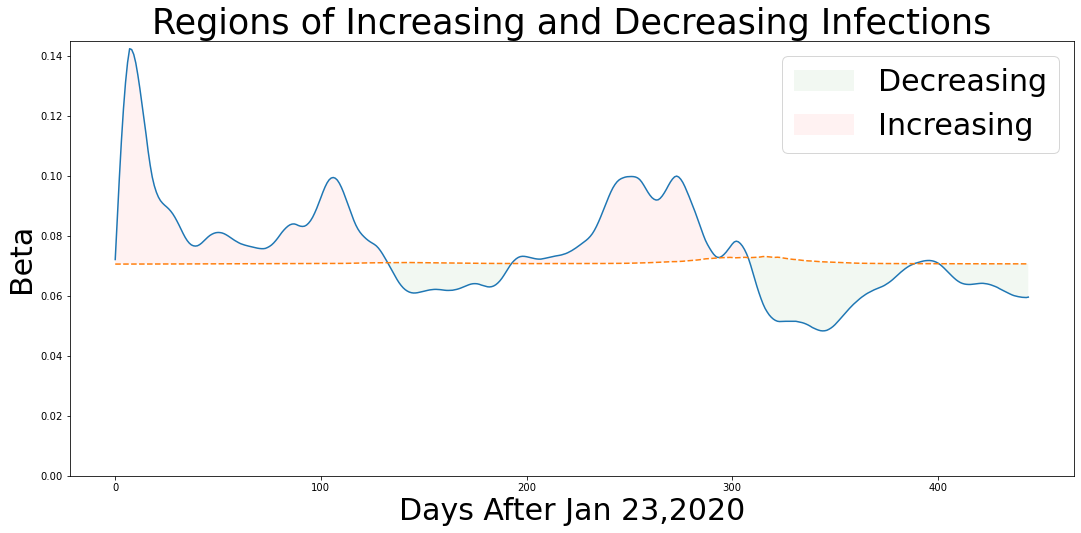

In [8]:
dates, infectRaw, recovRaw, deadRaw, vaccRaw = loadData(pathc + filename)

fig,ax = plt.subplots(figsize = (18,8))

q = 0.5
window = 13
hWin = window // 2
suscept = q * pop - infectRaw
file = "../Code/mean.csv"
csvfile=open(file, newline='', encoding='UTF-8')
rd = csv.reader(csvfile, delimiter=',')
data=[]

#for lv in rd: #generating the data matrix
#    data.append(lv)
#data = data[1:]
#data = np.array(data)
#beta = data[:,1].astype(float)
#ind = 0
#for i in range (len(beta)):
#    if(beta[i]):
#        ind = i
#        break
#print(ind)
beta = getBeta(pop, q, infectRaw, deadRaw, window)
beta = betaWithKernel(beta)
nu = getNu(infectRaw,deadRaw)
gamma = getGamma(infectRaw,deadRaw)
beta = beta[:445]
ax.plot(beta)
infect = infectRaw - approxRecovered(infectRaw,deadRaw) - deadRaw
temp = (((suscept+infect) / suscept) * (gamma + nu))[:445]
ax.plot(temp, linestyle = 'dashed')
import matplotlib.transforms as mtransforms
ymax = 0.145
ax.set_ylim(0,ymax)

trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(np.arange(0,445), beta / ymax, temp / ymax, where=temp > beta,alpha = 0.05,facecolor='green', transform=trans, label = "Decreasing")
ax.fill_between(np.arange(0,445), temp / ymax, beta / ymax, where=temp < beta,alpha = 0.05,facecolor='red', transform=trans, label = "Increasing")


ax.set_ylabel("Beta", fontsize = 30)
ax.set_xlabel("Days After Jan 23,2020", fontsize = 30)
ax.set_title("Regions of Increasing and Decreasing Infections", fontsize = 35)
ax.legend(fontsize = 30)

plt.savefig("../Figures/Regions of Increasing and Decreasing Infections.png", dpi=600, facecolor='w', edgecolor='w',orientation='portrait', format="png",transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

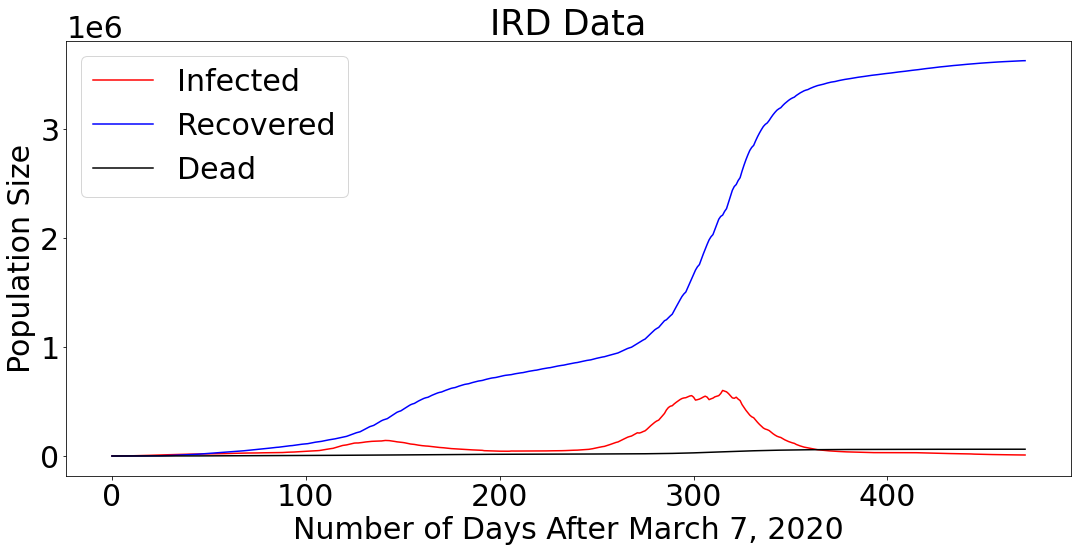

In [40]:
dates, infectRaw, recovRaw, deadRaw, vaccRaw = loadData(pathc + filename)

recov = approxRecovered(infectRaw, deadRaw)
infectRaw = infectRaw - recov - deadRaw


fig, ax = plt.subplots(figsize = (18,8))
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
ax.plot(infectRaw, color = 'red', label = 'Infected')
ax.plot(recov, color = 'blue', label = 'Recovered')
ax.plot(deadRaw, color = 'black', label = 'Dead')
ax.legend(fontsize = 30)

ax.set_title('IRD Data', fontsize = 35)
ax.set_xlabel('Number of Days After March 7, 2020', fontsize = 30)
ax.set_ylabel('Population Size', fontsize = 30)

plt.savefig("../Figures/IRD Graph.png", dpi=600, facecolor='w', edgecolor='w',orientation='portrait', format="png",transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)